# Generalised LR Parser
First introduced in 1965 by Knuth [1], LR is a bottom-up parsing technique that works by constructing an automaton, then traveling through it while consuming input one by one and maintaining a stack. A more detailed description about LR can be found [here](https://rahul.gopinath.org/post/2024/07/01/lr-parsing/).

Creating a grammar in LR(1), or even LR(k), can be difficult. Ideally, you want your grammar to be intuitive, easily understood, and readable. This is important because you'll make mistakes or change your mind in the future, and modifying a large grammar while making sure that it is in LR(1) is a painful process. Luckily, a more powerful parser, that can handle all context-free grammar, called Generalised LR (GLR) is available.
### Generalised LR
#### Handling conflicts in parse table
If you are familiar with LR, you probably know about *shift/reduce conflicts* (choices between shifting and reducing) and *reduce/reduce conflicts* (choices between reducing different rules), a normal LR parser cannot handle conflicts, as it does not know which choice to make. What we can do is incorporating a bit of breadth-first search, so the parser can try all options at the same time, and that is the main idea behind GLR.

For example, consider the following ambiguous grammar:
$$\begin{split} S &\rightarrow a \ B \ c & \hspace{1cm} (1)\\
S &\rightarrow a\ D \ c &\hspace{1cm} (2) \\
B &\rightarrow b &\hspace{1cm} (3) \\
D & \rightarrow b &\hspace{1cm} (4)\end{split}$$
For this grammar, the LR(1) automaton is as below:















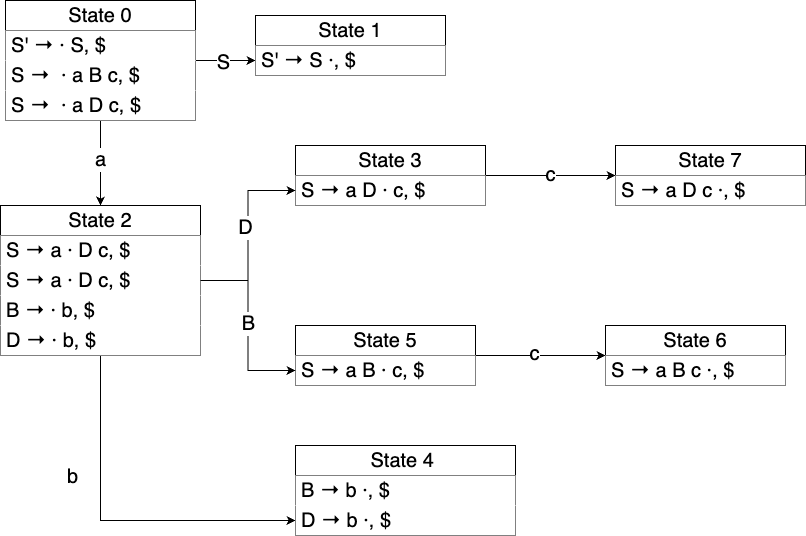

And the LR(1) parse table is:

| state | a   | b   | c               | $       | S   | B   | D   |
| ----- | --- | --- | --------------- | ------- | --- | --- | --- |
| 0     | p2  |     |                 |         | p1  |     |     |
| 1     |     |     |                 | acc     |     |     |     |
| 2     |     | p4  |                 |         |     | p5  | p3  |
| 3     |     |     | p7              |         |     |     |     |
| 4     |     |     | r(B, 3)/r(D, 4) |         |     |     |     |
| 5     |     |     | p6              |         |     |     |     |
| 6     |     |     |                 | r(S, 1) |     |     |     |
| 7     |     |     |                 | r(S, 2) |     |     |     |

In this table, "$pk$" is shift action, it means "go to state $k$" and $r(X, m)$ is the reduce action meaning "reduce symbol $X$ with rule numbered $m$." The symbol $\$$ is used to denote "end of string." There is a reduce/reduce conflict in state 4. Let's see what happens when we try to parse the string "abc".

| Step | Input | State | Stack                     | Next operation  |
| ---- | ----- | ----- | ------------------------- | --------------- |
| 0    | ""    | 0     | $\$, S_0$                 | p2              |
| 1    | "a"   | 2     | $\$, S_0, a, S_2$         | p4              |
| 2    | "ab"  | 4     | $\$, S_0, a, S_1, b, S_4$ | r(B, 3)/r(D, 4) |

A usual LR parser now has to choose between two possible reductions ($B \rightarrow b$ and $D \rightarrow b$). With GLR, it can attempt to try all options, but how would it do that? The simplest solution is to duplicate the stack and treat each stack as a separate process. After performing r(B, 3) action the stack is $\{\$, S_0, a, S_1, B, S_5\}$; similarly, we obtain $\{\$, S_0, a, S_1, D, S_3\}$ when r(D, 4) is applied. However, this approach is not ideal, the number of stacks can blow up exponentially, we need something more efficient.

#### Graph-Structured Stack (GSS)
In the above example, notice that the first four elements are the same in both stacks, therefore we can "share" them in a unified data structure. This is a "Graph-Structured Stack", or GSS, proposed by Tomita in his book [2].

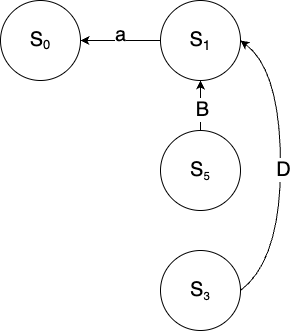

This image illustrates how nodes $S_0$ and $S_1$ are shared between the two stacks. As the name suggests, our stacks is now a single graph, and each element in the stack is a node. In the original Tomita's approach, elements $a$, $D$ and $B$ are individual nodes, but here we have simplified by making them the edge labels between states.

The nodes are divided into $n+1$ *levels,* with $n$ as the length of the input string. GSS construction is done level by level, and a new level is created upon a *shift* action. We define the GSSNode data structure as follow:

In [ ]:
class GSSNode:
    '''
        Represent a node in the GSS structure, nodes are indentified by id
    '''
    def __init__(self, level: int, id: int, label):
        self.level = level
        self.id = id
        self.label = label
        self.children: list[tuple['GSSNode', 'SPPFNode']] = []

    def __repr__(self):
        repr = f"Node({self.label})"
        return repr

    def __eq__(self, other):
        return self.id == other.id

    def __hash__(self):
        return hash(self.id)

    def add_child(self, child: 'GSSNode', edge):
        self.children.append((child, edge))

The GSS is a bit unusual. It does not perform the "pop" operation like an ordinary stack. Once a node is created, it is never removed. Instead of popping $m$ nodes out of the stack, we perform a traversal of length $m$ from the original node. For example, instead of popping 2 elements from node $S_3$, we traverse down the graph with length 2 and find that node $S_0$ is our target. We define a method to perform this operation

In [ ]:
class GSSNode(GSSNode):
    def find_paths_with_length(self, m: int) -> set[tuple['GSSNode',...]]:
        '''
            Find a set of nodes with length m from the origin node,
            return tuples of lenght m in a set, tuples contain all the labels and the destination node
        '''

        res: set[tuple] = set()

        def dfs(node: GSSNode, path: list[GSSNode]):
            if (len(path) >= m):
                res.add(tuple(path + [node]))
                return

            for child, edge in node.children:
                dfs(child, path + [edge])

        dfs(self, [])
        return res


### References
[1] D. E. Knuth, “On the translation of languages from left to right,” _Information and Control_, vol. 8, no. 6, pp. 607–639, Dec. 1965, doi: [10.1016/S0019-9958(65)90426-2](https://doi.org/10.1016/S0019-9958\(65\)90426-2).

[2] M. Tomita, _Efficient Parsing for Natural Language_. Boston, MA: Springer US, 1986. doi: [10.1007/978-1-4757-1885-0](https://doi.org/10.1007/978-1-4757-1885-0).